findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.


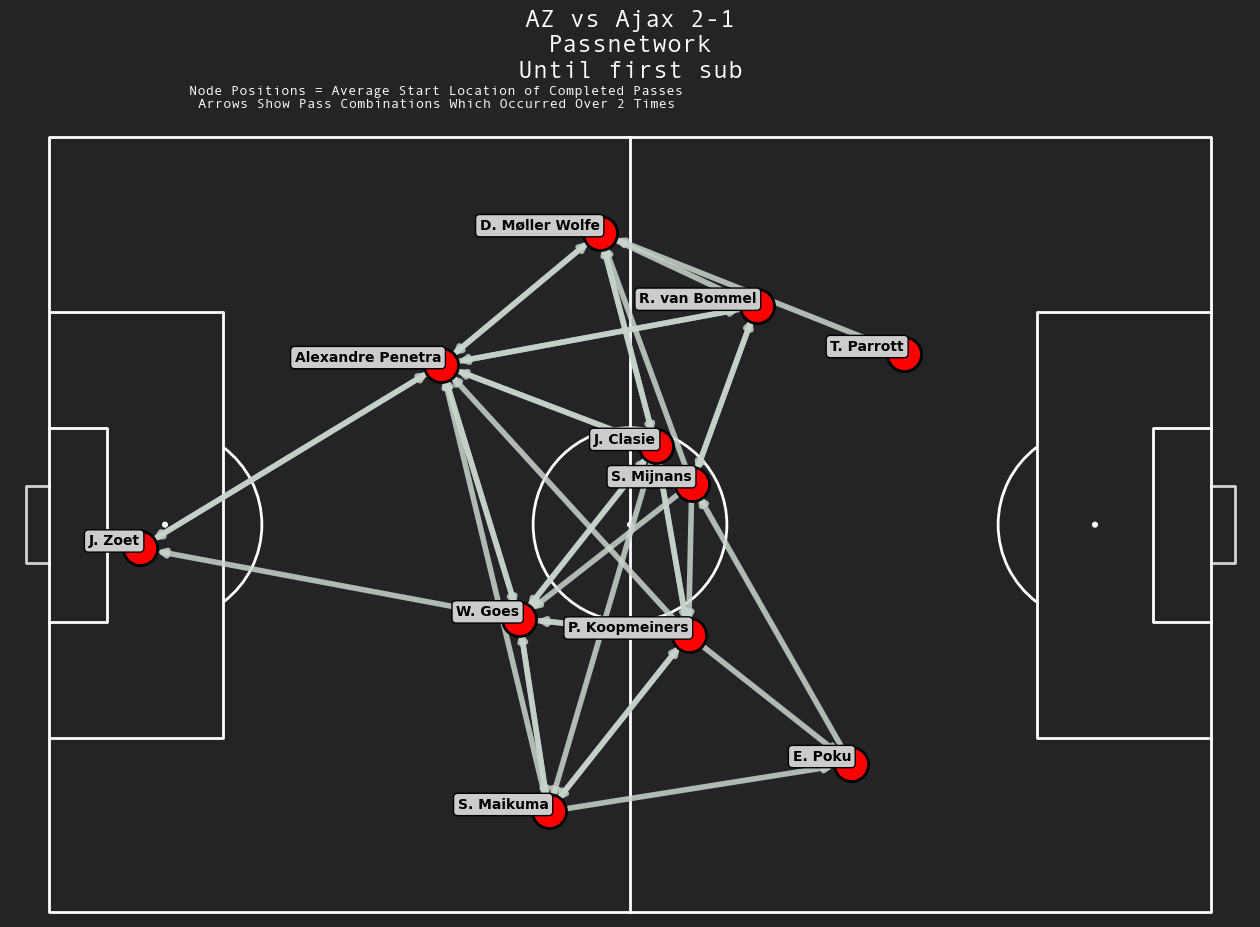

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib.colors as mpl_colors
import math
import mplsoccer

# Load data
df = pd.read_csv(r"/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie/AZ 2-1 Ajax.csv")

# Filter the data for one team
OneTeam = df.loc[(df['contestantId'] == '3kfktv64h7kg7zryax1wktr5r')].reset_index()

# Create a new column for time in seconds
OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]
OneTeam.sort_values(by=['newsecond'], inplace=True)

# Identify the passer and recipient
OneTeam['passer'] = OneTeam['playerName']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

# Filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
Completions = Passes.loc[(Passes['outcome'] == 1)]

# Find the time of the team's first substitution and filter passes before that
Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

# Filter completions before the first substitution
Completions = Completions.loc[Completions['newsecond'] < SubOne]

# Calculate average locations and count of passes
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Calculate passes between players
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

# Set a minimum threshold for pass arrows to be plotted
passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

# Make arrows less transparent if they have a higher count
min_transparency = 0.3
color = np.array(mpl_colors.to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(16, 11))

# Draw the pitch
pitch = mplsoccer.Pitch(pitch_type='statsbomb', pad_bottom=0.5, pad_top=5, pitch_color='#242424',
                        line_color='white', half=False, goal_type='box', goal_alpha=0.8)
pitch.draw(ax=ax)
fig.set_facecolor("#71797E")

# Function to draw pass lines
def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(1.2 * end_x, 80 - 0.8 * end_y), xytext=(1.2 * x, 80 - 0.8 * y), zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color='#c7d5cc', alpha=.85))

def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)

# Draw pass lines
for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'white')

# Plot nodes
pass_box = pitch.scatter(1.2 * average_locs_and_count.x, 80 - 0.8 * average_locs_and_count.y, s=600,
                         color='#FF0000', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2)

# Annotation/key at bottom
pitch.annotate("Node Positions = Average Start Location of Completed Passes\nArrows Show Pass Combinations Which Occurred Over 2 Times",
               (40, -4), color='white', fontsize=10, ha='center', va='center', ax=ax, fontweight='bold',
               fontfamily="Andale Mono")

# Annotate each node with the player id
for index, row in average_locs_and_count.iterrows():
     pitch.annotate(row.name, xy=(1.2 * row.x, 80 - 0.8 * row.y), bbox=dict(boxstyle="round", fc="0.8"), c='black',
                    va='bottom', ha='right', size=10, fontweight='bold', fontfamily="Century Gothic", ax=ax)

# Set the background color
fig.patch.set_facecolor('#242424')

# Set the title
ax.set_title("AZ vs Ajax 2-1\nPassnetwork\nUntil first sub", fontsize=18, color="w", fontfamily="Andale Mono",
             fontweight='bold', pad=8)

# Save and show the plot
plt.savefig('Passnetwork AZ vs Ajaz 2-1 Horizontal2.png', dpi=500, bbox_inches='tight', facecolor='#242424')
plt.show()


Global Metrics:
Network Density: 0.3273
Network Reciprocity: 0.6667
Network Assortativity: -0.1264

Player-Level Metrics:
                   In-Degree  Out-Degree  Betweenness  Closeness  \
J. Clasie                 22          29     0.233333   0.588235   
S. Mijnans                 8          12     0.194444   0.454545   
Alexandre Penetra         59          53     0.183333   0.714286   
S. Maikuma                11          14     0.164815   0.476190   
D. Møller Wolfe           29          25     0.100000   0.625000   
W. Goes                   46          46     0.083333   0.625000   
R. van Bommel             15           9     0.077778   0.588235   
P. Koopmeiners            16          22     0.074074   0.555556   
E. Poku                    7           3     0.066667   0.400000   
J. Zoet                   10           7     0.000000   0.500000   
T. Parrott                 0           3     0.000000   0.000000   

                    Eigenvector  Clustering  
J. Clasie      

findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.


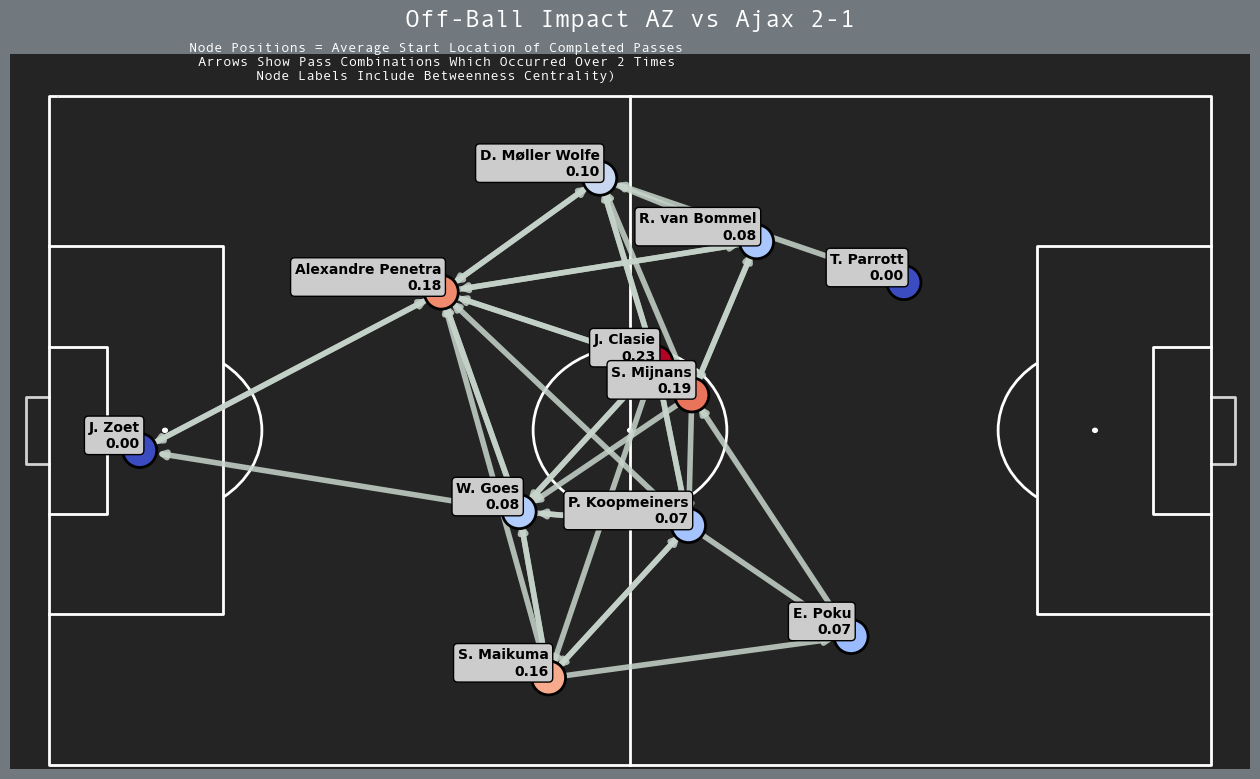

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import math
import mplsoccer
import networkx as nx
import matplotlib.image as mpimg  # For loading and displaying the logo

# Load data
df = pd.read_csv(r"/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie/AZ 2-1 Ajax.csv")

# Filter the data for one team
OneTeam = df.loc[(df['contestantId'] == '3kfktv64h7kg7zryax1wktr5r')].reset_index()

# Create a new column for time in seconds
OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]
OneTeam.sort_values(by=['newsecond'], inplace=True)

# Identify the passer and recipient
OneTeam['passer'] = OneTeam['playerName']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

# Filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
Completions = Passes.loc[(Passes['outcome'] == 1)]

# Find the time of the team's first substitution and filter passes before that
Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

# Filter completions before the first substitution
Completions = Completions.loc[Completions['newsecond'] < SubOne]

# Calculate average locations and count of passes
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Calculate passes between players
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

# Set a minimum threshold for pass arrows to be plotted
passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

# Build a directed graph from passes_between data
G = nx.DiGraph()

# Add edges with weights (pass counts)
for _, row in passes_between.iterrows():
    G.add_edge(row['passer'], row['recipient'], weight=row['pass_count'])

# Calculate Network Metrics
in_degree = dict(G.in_degree(weight='weight'))
out_degree = dict(G.out_degree(weight='weight'))
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality_numpy(G, weight='weight')
clustering = nx.clustering(G.to_undirected(), weight='weight')
reciprocity = nx.reciprocity(G)
assortativity = nx.degree_assortativity_coefficient(G, weight='weight')

density = nx.density(G)
if nx.is_strongly_connected(G):
    avg_path_length = nx.average_shortest_path_length(G, weight='weight')
else:
    avg_path_length = None  # Only valid for strongly connected networks

# Combine metrics into a DataFrame
metrics = pd.DataFrame({
    'In-Degree': in_degree,
    'Out-Degree': out_degree,
    'Betweenness': betweenness,
    'Closeness': closeness,
    'Eigenvector': eigenvector,
    'Clustering': clustering
}).fillna(0)
metrics = metrics.sort_values(by='Betweenness', ascending=False)

# Output global metrics
print("Global Metrics:")
print(f"Network Density: {density:.4f}")
print(f"Network Reciprocity: {reciprocity:.4f}")
print(f"Network Assortativity: {assortativity:.4f}")
if avg_path_length is not None:
    print(f"Average Path Length: {avg_path_length:.4f}")

print("\nPlayer-Level Metrics:")
print(metrics)

# Visualization
# Normalize betweenness centrality values for coloring
betweenness_values = pd.Series(betweenness)
max_betweenness = max(betweenness_values)
min_betweenness = min(betweenness_values)
norm_betweenness = (betweenness_values - min_betweenness) / (max_betweenness - min_betweenness)

# Define a colormap (e.g., 'coolwarm' or 'viridis')
cmap = plt.get_cmap('coolwarm')

# Apply the colormap to the normalized betweenness centrality values
node_colors = [cmap(norm_betweenness[node]) for node in average_locs_and_count.index]

# Make arrows less transparent if they have a higher count
min_transparency = 0.3
color = np.array(mpl_colors.to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(16, 11))

# Draw the pitch
pitch = mplsoccer.Pitch(pitch_type='statsbomb', pad_bottom=0.5, pad_top=5, pitch_color='#242424',
                        line_color='white', half=False, goal_type='box', goal_alpha=0.8)
pitch.draw(ax=ax)
fig.set_facecolor("#71797E")

# Function to draw pass lines
def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(1.2 * end_x, 80 - 0.8 * end_y), xytext=(1.2 * x, 80 - 0.8 * y), zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color='#c7d5cc', alpha=.85))

def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)

# Draw pass lines
for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'white')

# Plot nodes with the new colors based on betweenness centrality
pass_box = pitch.scatter(1.2 * average_locs_and_count.x, 80 - 0.8 * average_locs_and_count.y, s=600,
                         color=node_colors, edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2)

# Annotate each node with player id and betweenness centrality
for node, row in average_locs_and_count.iterrows():
    centrality = betweenness.get(node, 0)
    pitch.annotate(f"{row.name}\n{centrality:.2f}", xy=(1.2 * row.x, 80 - 0.8 * row.y),
                   bbox=dict(boxstyle="round", fc="0.8"), c='black',
                   va='bottom', ha='right', size=10, fontweight='bold', fontfamily="Century Gothic", ax=ax)

# Add annotation at the bottom of the plot
pitch.annotate("Node Positions = Average Start Location of Completed Passes\n"
               "Arrows Show Pass Combinations Which Occurred Over 2 Times\n"
               "Node Labels Include Betweenness Centrality)",
               (40, -4), color='white', fontsize=10, ha='center', va='center', ax=ax, fontweight='bold',
               fontfamily="Andale Mono")

# Add logo to the bottom right corner using imshow
logo_path = 'Outswinger FC.png'  # Provide the path to your logo image
logo_img = mpimg.imread(logo_path)
ax.imshow(logo_img, aspect='auto', extent=[0.85, 1, 0, 0.1], zorder=5)  # Adjust location as needed

# Set the title
ax.set_title("Off-Ball Impact AZ vs Ajax 2-1",
             fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=20)

# Adjust layout to make sure everything fits
plt.subplots_adjust(top=0.85, bottom=0.2)

# Save and show the plot
plt.savefig('Passnetwork_with_Metrics.png', dpi=500, bbox_inches='tight', facecolor='#242424')
plt.show()

# Save metrics to a CSV
metrics.to_csv('pass_network_metrics.csv', index=True)



Player-Level Metrics:
          Player  Betweenness
2    O. Boscagli     0.305556
0     J. Veerman     0.216667
8     W. Benítez     0.105556
7   Mauro Júnior     0.088889
5     I. Perišić     0.077778
1         G. Til     0.055556
4    R. Karsdorp     0.044444
3    R. Flamingo     0.033333
6     I. Saibari     0.011111
9     L. de Jong     0.000000
10    M. Tillman     0.000000

Player-Level Metrics with OBIS:
          Player  OBIS
2    O. Boscagli  0.31
0     J. Veerman  0.22
8     W. Benítez  0.11
7   Mauro Júnior  0.09
5     I. Perišić  0.08
1         G. Til  0.06
4    R. Karsdorp  0.04
3    R. Flamingo  0.03
6     I. Saibari  0.01
9     L. de Jong  0.00
10    M. Tillman  0.00


findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.


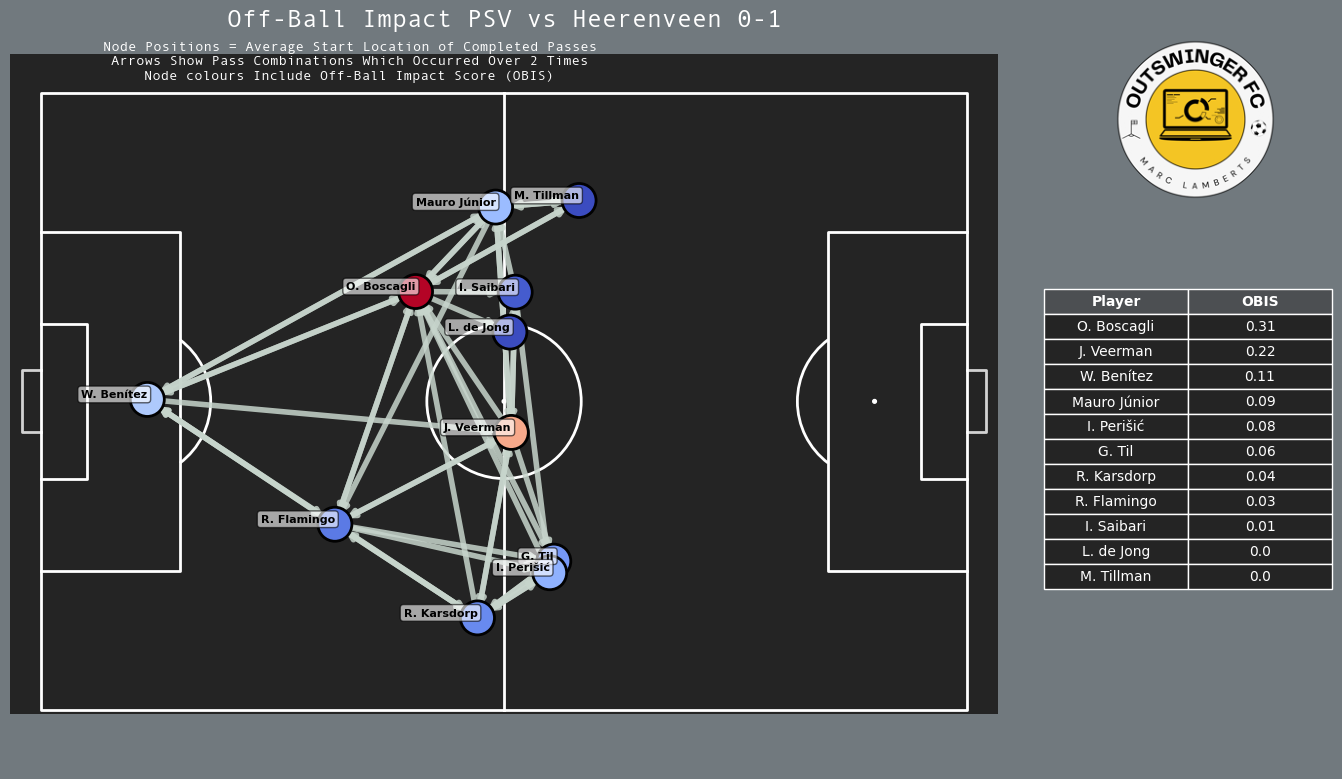

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import math
import mplsoccer
import networkx as nx
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  # New import for placing images

# Load data
df = pd.read_csv(r"/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie/Heerenveen 1-0 PSV.csv")

# Filter the data for one team
OneTeam = df.loc[(df['contestantId'] == '24fvcruwqrqvqa3aonf8c3zuy')].reset_index()

# Create a new column for time in seconds
OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]
OneTeam.sort_values(by=['newsecond'], inplace=True)

# Identify the passer and recipient
OneTeam['passer'] = OneTeam['playerName']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

# Filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
Completions = Passes.loc[(Passes['outcome'] == 1)]

# Find the time of the team's first substitution and filter passes before that
Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

# Filter completions before the first substitution
Completions = Completions.loc[Completions['newsecond'] < SubOne]

# Calculate average locations and count of passes
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Calculate passes between players
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

# Set a minimum threshold for pass arrows to be plotted
passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

# Build a directed graph from passes_between data
G = nx.DiGraph()

# Add edges with weights (pass counts)
for _, row in passes_between.iterrows():
    G.add_edge(row['passer'], row['recipient'], weight=row['pass_count'])

# Calculate Network Metrics
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)

# Combine metrics into a DataFrame
metrics = pd.DataFrame({
    'Player': list(betweenness.keys()),
    'Betweenness': list(betweenness.values())
}).sort_values(by='Betweenness', ascending=False)

# Output global metrics
print("\nPlayer-Level Metrics:")
print(metrics)

# Visualization
# Normalize betweenness centrality values for coloring
betweenness_values = pd.Series(betweenness)
max_betweenness = max(betweenness_values)
min_betweenness = min(betweenness_values)
norm_betweenness = (betweenness_values - min_betweenness) / (max_betweenness - min_betweenness)

# Define a colormap (e.g., 'coolwarm' or 'viridis')
cmap = plt.get_cmap('coolwarm')

# Apply the colormap to the normalized betweenness centrality values
node_colors = [cmap(norm_betweenness[node]) for node in average_locs_and_count.index]

# Make arrows less transparent if they have a higher count
min_transparency = 0.3
color = np.array(mpl_colors.to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(16, 11))

# Draw the pitch
pitch = mplsoccer.Pitch(pitch_type='statsbomb', pad_bottom=0.5, pad_top=5, pitch_color='#242424',
                        line_color='white', half=False, goal_type='box', goal_alpha=0.8)
pitch.draw(ax=ax)
fig.set_facecolor("#71797E")

# Function to draw pass lines
def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(1.2 * end_x, 80 - 0.8 * end_y), xytext=(1.2 * x, 80 - 0.8 * y), zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color='#c7d5cc', alpha=.85))

def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)

# Draw pass lines
for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'white')

# Plot nodes with the new colors based on betweenness centrality
pass_box = pitch.scatter(1.2 * average_locs_and_count.x, 80 - 0.8 * average_locs_and_count.y, s=600,
                         color=node_colors, edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2)

# Add annotation at the bottom of the plot
pitch.annotate("Node Positions = Average Start Location of Completed Passes\n"
               "Arrows Show Pass Combinations Which Occurred Over 2 Times\n"
               "Node colours Include Off-Ball Impact Score (OBIS)",
               (40, -4), color='white', fontsize=10, ha='center', va='center', ax=ax, fontweight='bold',
               fontfamily="Andale Mono")

# Set the title
ax.set_title("Off-Ball Impact PSV vs Heerenveen 0-1",
             fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=20)

# Adjust layout to make sure everything fits
plt.subplots_adjust(top=0.85, bottom=0.25)

# Rename 'Betweenness' to 'OBIS' and round the values to 2 decimal places
metrics.rename(columns={'Betweenness': 'OBIS'}, inplace=True)
metrics['OBIS'] = metrics['OBIS'].round(2)

# Output the updated metrics
print("\nPlayer-Level Metrics with OBIS:")
print(metrics)

# Create the table next to the plot with better styling
table_ax = fig.add_axes([0.85, 0.2, 0.18, 0.6])  # Positioning the table further to the right

# Plot the table with improved styling
table = table_ax.table(cellText=metrics.values,
                      colLabels=['Player', 'OBIS'],
                      loc='center', cellLoc='center', colLoc='center',
                      cellColours=[['#242424'] * 2] * len(metrics))  # Match pitch background color

# Add alternating row colors for better readability
for i, key in enumerate(metrics.index):
    if i % 2 == 0:
        table[(i+1, 0)].set_facecolor('#343a40')  # Slightly darker shade for alternating rows
        table[(i+1, 1)].set_facecolor('#343a40')

# Styling for header
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(12)
        cell.set_text_props(fontweight='bold', color='white')  # White font for header
        cell.set_facecolor('#4c4f52')  # Header background color
        cell.set_edgecolor('white')  # Set white border for header cells
    else:
        cell.set_fontsize(10)
        cell.set_text_props(color='white')  # White font for table content
        cell.set_facecolor('#242424')  # Table background color to match pitch
        cell.set_edgecolor('white')  # White borders

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Hide axes for the table
table_ax.axis('off')

# Add player name labels on the nodes
for node, row in average_locs_and_count.iterrows():
    centrality = betweenness.get(node, 0)
    pitch.annotate(f"{row.name}", xy=(1.2 * row.x, 80 - 0.8 * row.y),
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.6),
                   c='black', va='bottom', ha='right', size=8, fontweight='bold', fontfamily="Century Gothic", ax=ax)

logo_path = '/Users/marclambertes/Python/Outswinger FC (3).png'
logo_img = mpimg.imread(logo_path)

# Increase the zoom to make the logo bigger (e.g., change from 0.1 to 0.2)
imagebox = OffsetImage(logo_img, zoom=0.7, alpha=1)  # Adjust zoom for logo size

# Position the logo further to the right by adjusting the coordinates (e.g., 0.98, 0.8)
ab = AnnotationBbox(imagebox, (1.2, 0.9), frameon=False, xycoords='axes fraction', boxcoords="axes fraction",
                    box_alignment=(0.5, 0.5), pad=0)
ax.add_artist(ab)

# Save and show the plot
plt.savefig('Passnetwork_with_Metrics_and_Table_Styled_with_Logo.png', dpi=500, bbox_inches='tight', facecolor='#242424')
plt.show()

# Save metrics to a CSV
metrics.to_csv('pass_network_metrics.csv', index=True)


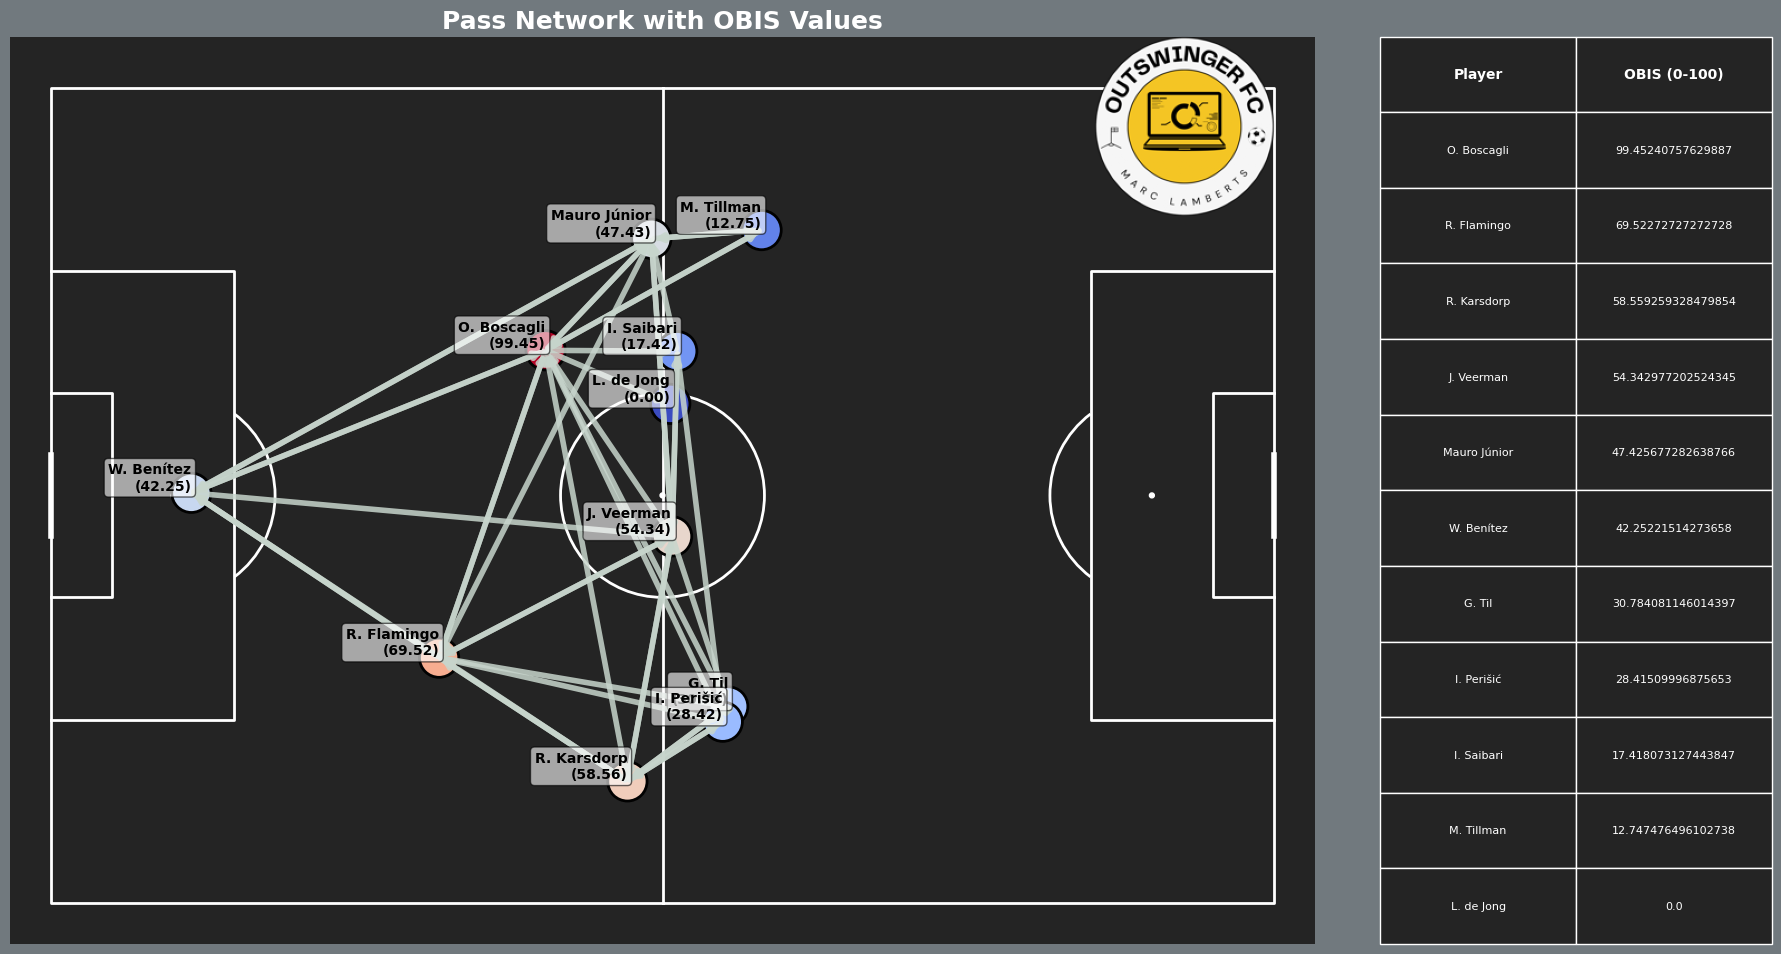

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import mplsoccer
import networkx as nx
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load data
df = pd.read_csv(r"/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie/Heerenveen 1-0 PSV.csv")

# Filter the data for one team
OneTeam = df.loc[(df['contestantId'] == '24fvcruwqrqvqa3aonf8c3zuy')].reset_index()

# Create a new column for time in seconds
OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]
OneTeam.sort_values(by=['newsecond'], inplace=True)

# Identify the passer and recipient
OneTeam['passer'] = OneTeam['playerName']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

# Filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
Completions = Passes.loc[(Passes['outcome'] == 1)]

# Find the time of the team's first substitution and filter passes before that
Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()
Completions = Completions.loc[Completions['newsecond'] < SubOne]

# Calculate average locations and count of passes
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Calculate passes between players
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])
passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

# Build a directed graph from passes_between data
G = nx.DiGraph()
for _, row in passes_between.iterrows():
    G.add_edge(row['passer'], row['recipient'], weight=row['pass_count'])

# Calculate network metrics
in_degree = dict(G.in_degree(weight='weight'))
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
eigenvector = nx.eigenvector_centrality_numpy(G, weight='weight')

# Normalize metrics (Min-Max Scaling)
metrics = pd.DataFrame({
    'Player': list(betweenness.keys()),
    'In-Degree': list(in_degree.values()),
    'Betweenness': list(betweenness.values()),
    'Eigenvector': list(eigenvector.values())
})
metrics['Normalized In-Degree'] = (metrics['In-Degree'] - metrics['In-Degree'].min()) / (metrics['In-Degree'].max() - metrics['In-Degree'].min())
metrics['Normalized Betweenness'] = (metrics['Betweenness'] - metrics['Betweenness'].min()) / (metrics['Betweenness'].max() - metrics['Betweenness'].min())
metrics['Normalized Eigenvector'] = (metrics['Eigenvector'] - metrics['Eigenvector'].min()) / (metrics['Eigenvector'].max() - metrics['Eigenvector'].min())

# OBIS formula
w1, w2, w3 = 0.5, 0.3, 0.2
metrics['OBIS'] = (
    w1 * metrics['Normalized In-Degree'] +
    w2 * metrics['Normalized Betweenness'] +
    w3 * metrics['Normalized Eigenvector']
)
metrics['OBIS (0-100)'] = metrics['OBIS'] * 100
metrics.sort_values(by='OBIS', ascending=False, inplace=True)

# Synchronize players between metrics and average locations
common_players = average_locs_and_count.index.intersection(metrics['Player'])
average_locs_and_count = average_locs_and_count.loc[common_players]
metrics = metrics[metrics['Player'].isin(common_players)]

# Normalize OBIS for coloring
obis_normalized = (metrics['OBIS'] - metrics['OBIS'].min()) / (metrics['OBIS'].max() - metrics['OBIS'].min())
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(obis_normalized[metrics['Player'] == player].values[0]) for player in average_locs_and_count.index]

# Visualization
fig, ax = plt.subplots(figsize=(18, 12))  # Increased figure size
pitch = mplsoccer.Pitch(pitch_type='statsbomb', pitch_color='#242424', line_color='white', pad_top=5)
pitch.draw(ax=ax)
fig.set_facecolor("#71797E")

# Title for the plot
plt.title("Pass Network with OBIS Values", fontsize=18, color="white", weight='bold')  # Larger title font

# Draw pass lines
for _, row in passes_between.iterrows():
    ax.annotate('', xy=(1.2 * row['x_end'], 80 - 0.8 * row['y_end']), xytext=(1.2 * row['x'], 80 - 0.8 * row['y']),
                arrowprops=dict(arrowstyle='-|>', color='#c7d5cc', alpha=0.85, lw=4))

# Draw nodes
pitch.scatter(1.2 * average_locs_and_count.x, 80 - 0.8 * average_locs_and_count.y, s=800,
              color=node_colors, edgecolors="#010101", linewidth=2, alpha=1, ax=ax)  # Larger nodes

# Annotate player names and OBIS
for node, row in average_locs_and_count.iterrows():
    if node in metrics['Player'].values:
        obis_value = metrics.loc[metrics['Player'] == node, 'OBIS (0-100)'].values[0]
    else:
        print(f"Warning: Player {node} not found in metrics.")
        obis_value = 0  # Default OBIS value for missing players
    
    pitch.annotate(f"{row.name}\n({obis_value:.2f})", xy=(1.2 * row.x, 80 - 0.8 * row.y),
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.6),
                   c='black', va='bottom', ha='right', size=10, fontweight='bold', ax=ax)  # Larger font

# Add team logo
logo_path = '/Users/marclambertes/Python/Outswinger FC (3).png'
logo_img = mpimg.imread(logo_path)
imagebox = OffsetImage(logo_img, zoom=0.8, alpha=1)  # Larger logo
ab = AnnotationBbox(imagebox, (0.9, 0.9), frameon=False, xycoords='axes fraction')
ax.add_artist(ab)

# Create a table with only the OBIS values
obis_table_data = metrics[['Player', 'OBIS (0-100)']]

# Set up the table
table = ax.table(cellText=obis_table_data.values,
                colLabels=obis_table_data.columns,
                loc='center right',
                cellLoc='center',
                colColours=['#444444'] * len(obis_table_data.columns),
                colWidths=[0.3] * len(obis_table_data.columns),
                bbox=[1.05, 0, 0.3, 1])  # Position of the table on the right

# Format table appearance
table.auto_set_font_size(False)
table.set_fontsize(8)  # Slightly larger font size for the table
table.scale(1.3, 1.5)  # Adjust table scaling
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(10)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#242424')  # Dark background
        cell.set_edgecolor('white')  # White borders
    else:
        cell.set_fontsize(8)
        cell.set_text_props(color='white')
        cell.set_facecolor('#242424')  # Dark background
        cell.set_edgecolor('white')  # White borders

# Adjust layout to fit the table
plt.subplots_adjust(right=0.85)

# Save and show the plot again
plt.savefig('Passnetwork_with_OBIS_table_right_updated_large.png', dpi=1000, bbox_inches='tight', facecolor='#242424')
plt.show()

# Save metrics to CSV
metrics.to_csv('pass_network_with_OBIS.csv', index=False)


Processing file: PSV 3-0 Go Ahead.csv
Processing file: Almere 3-0 Heerenveen.csv
No successful passes found in Almere 3-0 Heerenveen.csv. Skipping this file.
Processing file: Waalwijk 2-0 Almere.csv
No successful passes found in Waalwijk 2-0 Almere.csv. Skipping this file.
Processing file: Twente 2-0 Groningen.csv
No successful passes found in Twente 2-0 Groningen.csv. Skipping this file.
Processing file: Sparta 0-0 Heracles.csv
No successful passes found in Sparta 0-0 Heracles.csv. Skipping this file.
Processing file: Heracles 2-2 Waalwijk.csv
No successful passes found in Heracles 2-2 Waalwijk.csv. Skipping this file.
Processing file: PSV 3-0 Feyenoord.csv
Processing file: Willem II 2-2 NAC.csv
No successful passes found in Willem II 2-2 NAC.csv. Skipping this file.
Processing file: Twente 3-2 Go Ahead.csv
No successful passes found in Twente 3-2 Go Ahead.csv. Skipping this file.
Processing file: PSV 6-1 Twente.csv
Processing file: PSV 6-0 Zwolle.csv
Processing file: Almere 1-3 Utrec

Processing file: Twente 2-2 Ajax.csv
No successful passes found in Twente 2-2 Ajax.csv. Skipping this file.
Processing file: NAC 1-0 NEC.csv
No successful passes found in NAC 1-0 NEC.csv. Skipping this file.
Processing file: Waalwijk 0-3 AZ.csv
No successful passes found in Waalwijk 0-3 AZ.csv. Skipping this file.
Processing file: Heerenveen 4-0 NAC.csv
No successful passes found in Heerenveen 4-0 NAC.csv. Skipping this file.
Processing file: Utrecht 0-2 Feyenoord.csv
No successful passes found in Utrecht 0-2 Feyenoord.csv. Skipping this file.
Processing file: Zwolle 1-5 Feyenoord.csv
No successful passes found in Zwolle 1-5 Feyenoord.csv. Skipping this file.
Processing file: NAC 1-2 Utrecht.csv
No successful passes found in NAC 1-2 Utrecht.csv. Skipping this file.
Processing file: Sparta 1-1 Feyenoord.csv
No successful passes found in Sparta 1-1 Feyenoord.csv. Skipping this file.
Processing file: Ajax 2-2 Utrecht.csv
No successful passes found in Ajax 2-2 Utrecht.csv. Skipping this fi

findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.


findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.
findfont: Font family 'Century Gothic' not found.


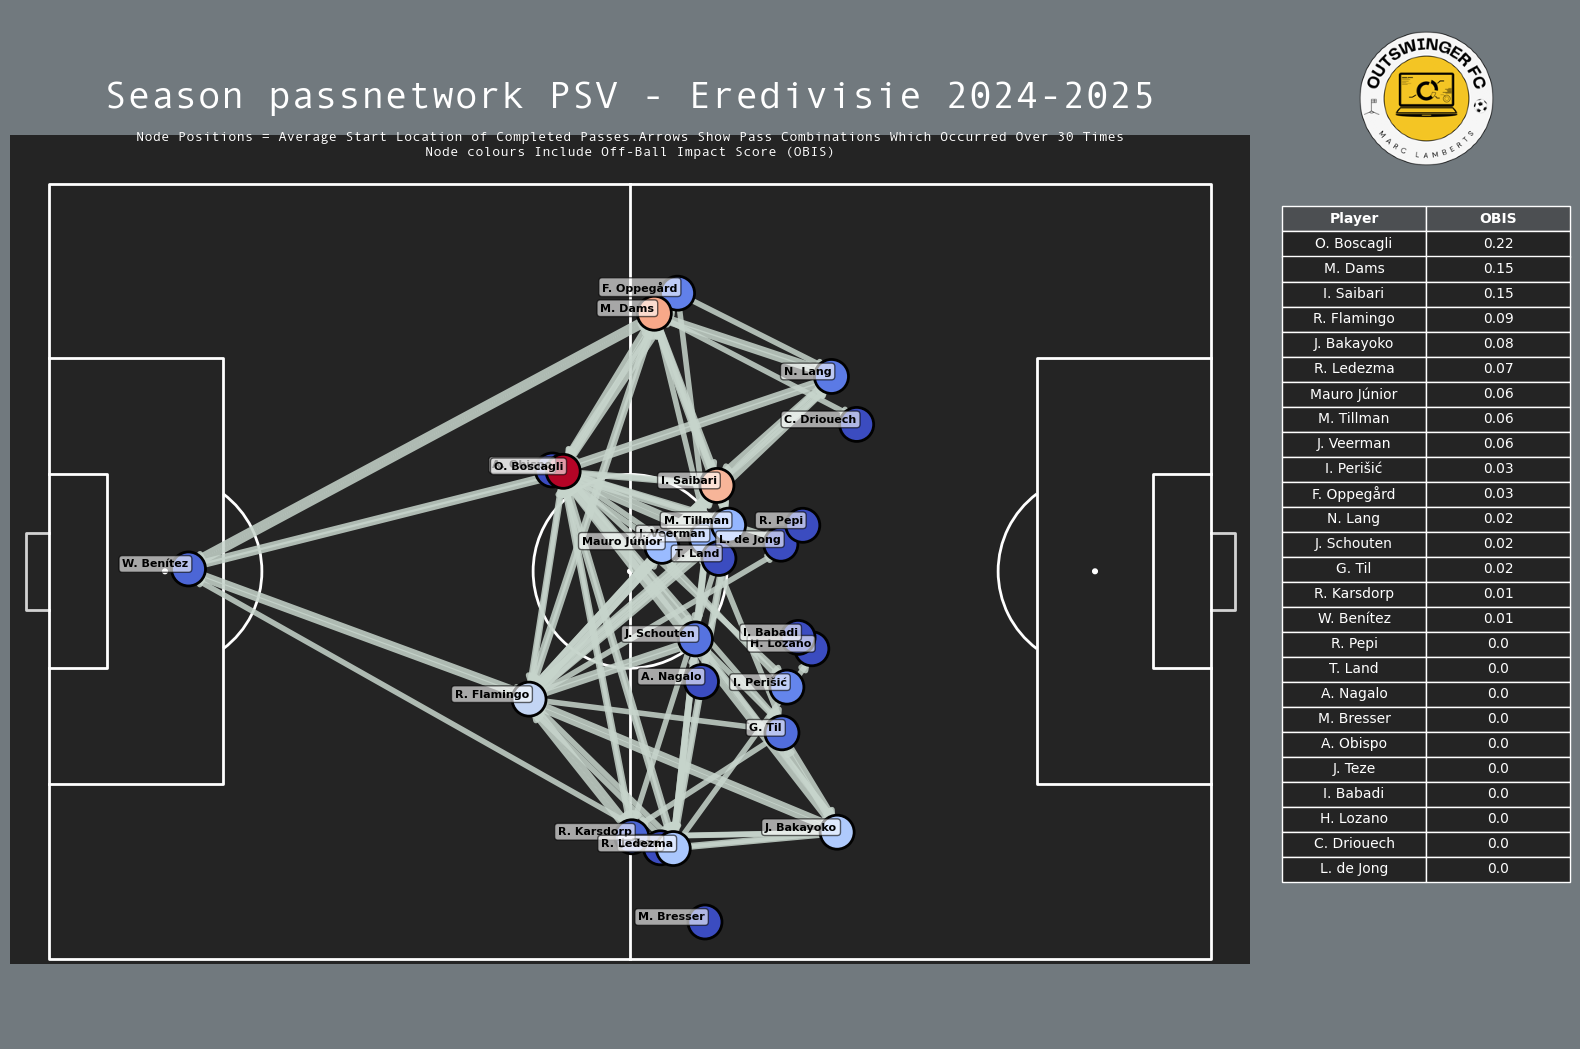

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import math
import mplsoccer
import networkx as nx
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

# Define folder path containing match data
folder_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie/"

# Get the list of CSV files
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize an empty DataFrame for storing all completions
all_completions = pd.DataFrame()

# Loop through each file
for file in file_list:
    print(f"Processing file: {file}")
    df = pd.read_csv(os.path.join(folder_path, file))
    
    # Filter the data for the desired team
    one_team = df[df['contestantId'] == '24fvcruwqrqvqa3aonf8c3zuy'].reset_index()
    
    # Create a new column for time in seconds
    one_team["newsecond"] = 60 * one_team["timeMin"] + one_team["timeSec"]
    one_team.sort_values(by=['newsecond'], inplace=True)
    
    # Create passer and recipient columns
    if 'playerName' in one_team.columns:
        one_team['passer'] = one_team['playerName']
        one_team['recipient'] = one_team['passer'].shift(-1)
    else:
        print(f"Error: Column 'playerName' not found in {file}. Skipping this file.")
        continue
    
    # Filter for only passes and then successful passes
    passes = one_team[one_team['typeId'] == 1]
    completions = passes[passes['outcome'] == 1]
    
    # Handle empty completions
    if completions.empty:
        print(f"No successful passes found in {file}. Skipping this file.")
        continue
    
    # Concatenate to the global DataFrame
    all_completions = pd.concat([all_completions, completions], ignore_index=True)

# Check the aggregated data
print(all_completions.head())
print(all_completions.columns)

# Ensure there is data for processing
if all_completions.empty:
    raise ValueError("No valid pass completion data found across all files.")

# Calculate average locations and pass counts
average_locs_and_count = all_completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Calculate passes between players
passes_between = all_completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

# Filter for significant pass combinations
passes_between = passes_between[passes_between['pass_count'] > 30]

# Build a directed graph
G = nx.DiGraph()

for _, row in passes_between.iterrows():
    G.add_edge(row['passer'], row['recipient'], weight=row['pass_count'])

# Calculate betweenness centrality (Off-Ball Impact Score - OBIS)
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)

# Create a metrics DataFrame with OBIS rounded to two decimal places
metrics = pd.DataFrame({
    'Player': list(betweenness.keys()),
    'OBIS': list(betweenness.values())
}).sort_values(by='OBIS', ascending=False)

# Format OBIS column to two decimal places
metrics['OBIS'] = metrics['OBIS'].apply(lambda x: f"{x:.2f}")

# Normalize betweenness values for visualization
min_betweenness = min(betweenness.values())
max_betweenness = max(betweenness.values())
norm_betweenness = (pd.Series(betweenness) - min_betweenness) / (max_betweenness - min_betweenness)

# Ensure all players have normalized values
norm_betweenness_full = pd.Series(index=average_locs_and_count.index, dtype=float)
norm_betweenness_full.update(norm_betweenness)
norm_betweenness_full.fillna(0, inplace=True)  # Assign 0 to players missing in the betweenness calculation

# Visualization setup
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(norm_betweenness_full[node]) for node in average_locs_and_count.index]
min_transparency = 0.3
color = np.array(mpl_colors.to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

# Plotting
fig, ax = plt.subplots(figsize=(16, 11))
pitch = mplsoccer.Pitch(pitch_type='statsbomb', pad_bottom=0.5, pad_top=5, pitch_color='#242424',
                        line_color='white', half=False, goal_type='box', goal_alpha=0.8)
pitch.draw(ax=ax)
fig.set_facecolor("#71797E")

# Function to draw pass lines
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    ax.annotate('', xy=(1.2 * end_x, 80 - 0.8 * upd_y), xytext=(1.2 * x, 80 - 0.8 * y), zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color='#c7d5cc', alpha=.85))

# Draw pass lines
for _, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'white')

# Plot nodes
pitch.scatter(1.2 * average_locs_and_count.x, 80 - 0.8 * average_locs_and_count.y, s=600,
              color=node_colors, edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2)

# Add annotation at the bottom of the plot
pitch.annotate(
    "Node Positions = Average Start Location of Completed Passes.Arrows Show Pass Combinations Which Occurred Over 30 Times\n"
    "Node colours Include Off-Ball Impact Score (OBIS)",
    (60, -4), color='white', fontsize=10, ha='center', va='center', ax=ax, fontweight='bold', fontfamily="Andale Mono"
)

# Set the title
ax.set_title(
    "Season passnetwork PSV - Eredivisie 2024-2025",
    fontsize=28, color="w", fontfamily="Andale Mono", fontweight='bold', pad=20
)

# Create the table next to the plot with better styling
table_ax = fig.add_axes([0.92, 0.05, 0.18, 0.9])  # Adjusted height to fit all players

# Ensure the metrics table includes all players, even those with 0 OBIS
all_players_metrics = pd.DataFrame(index=average_locs_and_count.index)
all_players_metrics['OBIS'] = all_players_metrics.index.map(betweenness).fillna(0)  # Fill missing OBIS with 0
all_players_metrics = all_players_metrics.reset_index().rename(columns={'index': 'Player'}).sort_values(by='OBIS', ascending=False)

# Round OBIS to 2 decimal places
all_players_metrics['OBIS'] = all_players_metrics['OBIS'].round(2)

# Plot the table
table = table_ax.table(cellText=all_players_metrics.values,
                       colLabels=['Player', 'OBIS'],
                       loc='center', cellLoc='center', colLoc='center',
                       cellColours=[['#242424'] * 2] * len(all_players_metrics))  # Match pitch background color

# Add alternating row colors for better readability
for i, key in enumerate(all_players_metrics.index):
    if i % 2 == 0:
        table[(i + 1, 0)].set_facecolor('#343a40')  # Slightly darker shade for alternating rows
        table[(i + 1, 1)].set_facecolor('#343a40')

# Styling for header
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(12)
        cell.set_text_props(fontweight='bold', color='white')  # White font for header
        cell.set_facecolor('#4c4f52')  # Header background color
        cell.set_edgecolor('white')  # Set white border for header cells
    else:
        cell.set_fontsize(10)
        cell.set_text_props(color='white')  # White font for table content
        cell.set_facecolor('#242424')  # Table background color to match pitch
        cell.set_edgecolor('white')  # White borders

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Hide axes for the table
table_ax.axis('off')

# Add logo above the table
logo_path = 'Outswinger FC (3).png'
if os.path.exists(logo_path):
    logo_img = mpimg.imread(logo_path)
    imagebox = OffsetImage(logo_img, zoom=0.6, alpha=1)
    
    # Place the logo above the table using the table_ax axis
    ab = AnnotationBbox(imagebox, (0.5, 0.95), xycoords='axes fraction', frameon=False)  # Adjusted to place above
    table_ax.add_artist(ab)  # Use `table_ax` instead of `fig`

# Annotate nodes with player names
for player, row in average_locs_and_count.iterrows():
    pitch.annotate(player, xy=(1.2 * row.x, 80 - 0.8 * row.y),
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.6),
                   c='black', va='bottom', ha='right', size=8, fontweight='bold', fontfamily="Century Gothic", ax=ax)

# Save the plot
plt.savefig('/Users/marclambertes/Python/Eredivisie review/Passnetwork/Passnetwork Season PSV.png', dpi=1000, bbox_inches='tight', facecolor='#242424')

# Show the plot
plt.show()
